# Yahoo finance를 이용하여 sp500 주식 데이터 불러오기

In [3]:
import pandas as pd
import yfinance as yf
import datetime

In [4]:
# get sp500 list from wikipedia by pandas
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500 = pd.read_html(url)
sp500 = sp500[0][["Symbol", "Date added"]]

# Fill NaN values with a default date
# Fill NaN values with a default date
sp500['Date added'] = sp500['Date added'].fillna('1900-01-01')

# Convert 'Date added' to datetime format
sp500['Date added'] = pd.to_datetime(sp500['Date added'], errors='coerce', format='%Y-%m-%d')

end_time = datetime.datetime.today()
start_time = end_time - pd.DateOffset(months = 26)

# Select sp500_list where 'Date added' is before start_time
sp500_list = sp500[sp500["Date added"] <= start_time]["Symbol"].tolist()

In [5]:
# download data from yahoo finance
data_1d = yf.download(sp500_list, start = start_time, end = end_time, interval = "1d")["Adj Close"]


[*********************100%%**********************]  470 of 470 completed

2 Failed downloads:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-04-01 18:01:46.698582 -> 2024-06-01 18:01:46.698582)')


# 페어 트레이딩을 위한 고상관 주식 조합 도출

## 데이터 구간 나누기

In [6]:
# split data into three parts

# 365 days for correlation matrix
start_time_correlation = start_time 
final_time_correlation = start_time_correlation + pd.DateOffset(months = 12)

# 365 days for backtesting
start_time_backtesting = final_time_correlation + pd.DateOffset(days = 1)
final_time_backtesting = end_time - pd.DateOffset(days = 60)

# 60 days for reassurance for backtesting with high frequency (Intraday)
start_time_reassurance = final_time_backtesting + pd.DateOffset(days = 1)
final_time_reassurance = end_time

# check if the duration of reassurance is 60 days which means the difference between final_time_reassurance and start_time_reassurance is 59 days
final_time_reassurance - start_time_reassurance


Timedelta('59 days 00:00:00')

In [7]:
yf.download("AAPL", start = start_time_reassurance, end = final_time_reassurance, interval = "5m")["Adj Close"]

[*********************100%%**********************]  1 of 1 completed


Datetime
2024-04-04 09:30:00-04:00    170.279999
2024-04-04 09:35:00-04:00    170.839996
2024-04-04 09:40:00-04:00    170.529999
2024-04-04 09:45:00-04:00    170.734207
2024-04-04 09:50:00-04:00    170.779999
                                ...    
2024-05-31 15:35:00-04:00    191.154999
2024-05-31 15:40:00-04:00    191.434998
2024-05-31 15:45:00-04:00    191.860107
2024-05-31 15:50:00-04:00    192.259995
2024-05-31 15:55:00-04:00    192.470001
Name: Adj Close, Length: 3196, dtype: float64

In [8]:
data_1d_corr = data_1d.loc[start_time_correlation:final_time_correlation].copy() #inclusive:inclusive
correlation_matrix = data_1d_corr.corr()
correlation_matrix

Ticker,A,AAL,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Ticker,,,,,,,,,,,,,,,,,,,,,
A,1.000000,-0.006932,-0.163027,0.486792,0.056084,-0.024528,-0.256235,0.536592,0.389474,0.639264,...,0.873562,-0.344021,0.683669,-0.055840,0.834994,0.927126,0.802430,0.604901,-0.318589,-0.299502
AAL,-0.006932,1.000000,0.386089,0.181629,0.672127,0.537265,0.578233,0.283599,0.155398,-0.216466,...,0.304336,0.755805,0.257670,0.352151,-0.102073,-0.131319,0.192077,0.527032,0.754302,0.608883
AAPL,-0.163027,0.386089,1.000000,-0.167320,0.169522,0.656851,0.571263,0.259681,0.027462,0.174910,...,-0.069282,0.443671,-0.010648,0.396616,-0.321330,-0.126644,-0.074050,0.109184,0.648546,0.607510
ABBV,0.486792,0.181629,-0.167320,1.000000,0.236509,0.037090,-0.045157,0.405978,0.251451,0.162994,...,0.668975,-0.049965,0.527412,-0.049841,0.335142,0.429204,0.673249,0.675025,-0.045380,0.029182
ABT,0.056084,0.672127,0.169522,0.236509,1.000000,0.684411,0.695129,0.084207,0.202446,0.006368,...,0.254097,0.773405,-0.028238,0.632142,-0.285394,-0.154858,0.145756,0.436687,0.699142,0.593846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYL,0.927126,-0.131319,-0.126644,0.429204,-0.154858,-0.102119,-0.376953,0.505369,0.446523,0.720682,...,0.791119,-0.463640,0.630392,-0.087807,0.835721,1.000000,0.738632,0.496555,-0.467071,-0.465513
YUM,0.802430,0.192077,-0.074050,0.673249,0.145756,-0.015828,-0.027096,0.786848,0.119558,0.306359,...,0.853098,-0.148326,0.850644,-0.002167,0.705362,0.738632,1.000000,0.760765,-0.108513,0.012431
ZBH,0.604901,0.527032,0.109184,0.675025,0.436687,0.206413,0.204065,0.693090,0.280046,0.139449,...,0.824911,0.180098,0.779803,0.178776,0.443366,0.496555,0.760765,1.000000,0.280225,0.215395


In [9]:
correlation_values = correlation_matrix.values.flatten()
correlation_values = correlation_values[(correlation_values != 1)]
correlation_values

array([-0.00693186, -0.1630269 ,  0.48679191, ...,  0.01243062,
        0.21539538,  0.88923591])

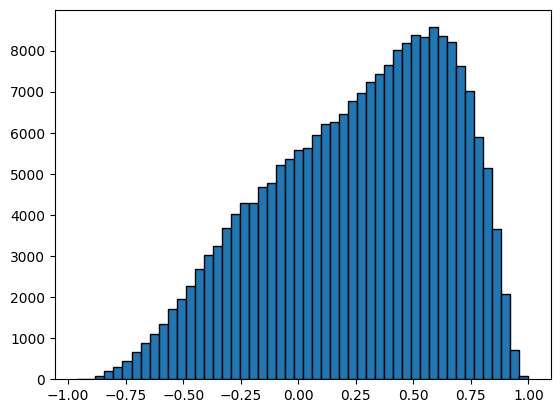

In [10]:
import matplotlib.pyplot as plt
# plot histogram
plt.hist(correlation_values, bins = 50, edgecolor = "black")
plt.show()

In [11]:
import numpy as np

# Create a boolean mask for the upper triangle of the matrix
mask_upper_triangle = np.triu(np.ones(correlation_matrix.shape), k=1)

# Apply the mask to the correlation matrix, this will remain values only in the upper triangle
upper_corr_matrix = np.multiply(correlation_matrix, mask_upper_triangle)

# Reshape the DataFrame from a 2D table to a 1D series, preserving row and column labels
stacked_corr = upper_corr_matrix.stack()

# Sort the correlation values in descending order
sorted_corr = stacked_corr.sort_values(ascending=False)

# Select the top 3000 pairs
high_correlated_pairs = sorted_corr.index[0:3000].tolist()

# 고상관 주식의 시계열 분석: Plotly 인터렉티브 차트

In [12]:
high_correlated_pairs[0:10]

[('GOOG', 'GOOGL'),
 ('NWS', 'NWSA'),
 ('FOX', 'FOXA'),
 ('AVB', 'EQR'),
 ('EQR', 'UDR'),
 ('AVB', 'UDR'),
 ('CPT', 'UDR'),
 ('AVB', 'ESS'),
 ('EQR', 'ESS'),
 ('EXPE', 'RHI')]

In [13]:
from ipywidgets import interact, Output, widgets
from plotly import graph_objs as go
from IPython.display import display, clear_output


# Create dropdown widget for pairs
pair_dropdown = widgets.Dropdown(
    options=[(pair, pair) for pair in high_correlated_pairs],
)

# Create the output widget for displaying the plot
plot_output = Output()

# Display the empty output widget once
display(plot_output)

# Function to update graph
def update_graph(selected_pair):
    with plot_output:
        # remove the graph in the output cell already
        clear_output(wait=True)
        # Extract individual stocks from the selected pair
        
        fig = go.Figure()
        
        # Add trace for stock1 using the primary y-axis
        fig.add_trace(go.Scatter(x = data_1d.index, y = data_1d[selected_pair[0]], name = selected_pair[0], yaxis = "y1"))
        
        # Add trace for stock2 using the secondary y-axis       
        fig.add_trace(go.Scatter(x = data_1d.index, y = data_1d[selected_pair[1]], name = selected_pair[1], yaxis = "y2"))
        # Update layout to include a second y-axis
        fig.update_layout(
            yaxis=dict(title=selected_pair[0], titlefont=dict(color="blue"), tickfont=dict(color="blue")),
            yaxis2=dict(title=selected_pair[1], titlefont=dict(color="red"), tickfont=dict(color="red"), overlaying="y", side="right"),
            title="Stock Prices Over Time",
            xaxis_title="Date"
        )

        
        
        fig.show()

# Create interactive widget
interact(update_graph, selected_pair=pair_dropdown);

Output()

interactive(children=(Dropdown(description='selected_pair', options=((('GOOG', 'GOOGL'), ('GOOG', 'GOOGL')), (…

# 페어 트레이딩 전략 구현: OOP Part 1

### CLASS와 OBJECT
    - 클래스를 이용하여 객체를 생성하고 활용할 수 있습니다. 
    - 객체는 클래스의 구체화이며 속성 (attributes)과 동작(메서드)을 가지고 있는 프로그래밍 구성 요소입니다.
    - 클래스에 매개변수 (arguments)를 입력하고
    - 매개변수는 객체의 속성(attributes)에 할당됩니다. 
    - 객체 생성은 __init__(self, **args)을 통하여 이루어집니다. 

## PairTradingFinancialAnalysis 클래스 생성

In [14]:
class PairTradingFinancialAnalysis:

    # attributes (속성)
    def __init__(self, pair, df_whole, window, zscore_threshold, margin_init, margin_ratio):
        self.stock1, self.stock2 = pair[0], pair[1]
        self.window = window
        self.zscore_threshold = zscore_threshold
        self.margin_init = margin_init
        self.margin_ratio = margin_ratio
        self.margin = margin_init
        self.df_pair = df_whole.loc[:, pair].copy()
        self.df_signal_summary = pd.DataFrame()
        self.df_margin = pd.DataFrame()

        
    def __repr__(self): 
        return f"PairTradingFinancialAnalysis(pair = {self.stock1} and {self.stock2}, window = {self.window}, zscore_threshold = {self.zscore_threshold}, margin_init = {self.margin_init}, margin_ratio = {self.margin_ratio})"
    
    # methods (메소드)
    def zscore_calculation(self):
        """
        주어진 주식 Pair에 윈도우를 기반으로 가격 비율의 이동 평균, 이동 표준 편차를 기반으로 zscore를 계산합니다.
        
        Attributes (속성): 
            - self.pair (튜플): 분석할 주식 쌍의 주식 심볼을 포함하는 튜플입니다.
            - self.df_pair (DataFrame): 분석할 주식에 대한 주식 가격을 포함하는 DataFrame입니다.
            - self.window (정수): 이동 평균과 이동 편차을 계산하는 데 사용되는 일수 (days)입니다.

        Reseults (결과):
            - 현재 가격 비율과 주어진 윈도우의 과거로부터의 이동 평균, 이동 표준 편차를 추가하여 zscore를 계산하여 self.df를 업데이트합니다.
        """
        self.df_pair["ratio"] = self.df_pair[self.stock1] / self.df_pair[self.stock2]
        self.df_pair["ma"] = self.df_pair["ratio"].rolling(window=self.window).mean().shift(1)
        self.df_pair["msd"] = self.df_pair["ratio"].rolling(window=self.window).std().shift(1)
        self.df_pair["zscore"] = (self.df_pair["ratio"] - self.df_pair["ma"]) / self.df_pair["msd"]

    
    def signal_calculation(self):
        """
        zscore와 zscore_threshold를 비교하여 거래 신호를 계산합니다.
        
        Attributes (속성):
            - self.df_pair (DataFrame): zscore_calculation에서 얻은 DataFrame입니다.
            - self.zscore_threshold (float): 거래 신호를 결정하는 데 사용되는 기준 값입니다.

        Reseults (결과):
            - zscore (stock1/stock2에 비례), zscore_threshold, 그리고 신호를 포함하여 self.df_pair를 업데이트합니다.
            - zscore > zscore_threshold는 stock1이 stock2에 비해 통계적으로 유의미하게 고평가되었다는 것을 의미하고 이는 stock1을 매도(short)하고 stock2를 매입(Long)해야 함을 의미하고 이를 signal = -1로 표시합니다.
            - zscore < -zscore_threshold는 stock1이 stock2에 비해 통계적으로 유의미하게 저평가되었다는 것을 의미하고 이는 stock1을 매입(Long)하고 stock2를 매도(Short)해야 함을 의미하고 이를 signal = 1로 표시합니다.
            - zscore가 -1과 1 사이에 있는 경우에는 stock1과 stock2가 통계적으로 유의미하게 평가되지 않았다는 것을 의미하고 이는 stock1과 stock2를 매도하거나 매입하지 않아야 함을 의미하고 이를 signal = 0으로 표시합니다.
            - zscore가 5보다 크거나 -5보다 작은 경우에는 거래를 하지 않습니다. 왜냐하면 이러한 경우는 통계의 표준에서 너무 크게 벗어난 경우이기 (예를 들어, 주식 가격의 폭락) 때문에 어떤 결정을 바꾸는 것이 리스크가 될 수 있습니다. 주식 가격의 폭락이나 폭등을 기준으로 거래를 하는 방법론도 있으나 우리의 방법론은 철저히 통계에 기반하기 때문에 통계로 해석이 어려운 특수한 경우는 거래에서 제외합니다. 
            - 위에 명시된 경우에 해당되지 않는 경우는 signal을 유지함을 의미하므로 기존 signal을 ffill()을 사용하여 앞으로 채우고, 남은 NaN 값을 0으로 채웁니다.
        """
        import numpy as np
        self.df_pair['signal'] = np.nan
        self.df_pair['signal'] = np.where((self.df_pair['zscore'] > self.zscore_threshold) & (self.df_pair['zscore'] < 5), -1, self.df_pair['signal'])
        self.df_pair['signal'] = np.where((self.df_pair['zscore'] < -self.zscore_threshold) & (self.df_pair['zscore'] > -5), 1, self.df_pair['signal'])
        self.df_pair['signal'] = np.where((self.df_pair['zscore'] > -1) & (self.df_pair['zscore'] < 1), 0, self.df_pair['signal'])
        self.df_pair['signal'] = self.df_pair['signal'].ffill()
        self.df_pair['signal'] = self.df_pair['signal'].fillna(0)                                

    def signal_summary(self):
        """
        self.df_pair를 signal을 바탕으로 그룹화하고, 시작 및 종료 날짜, 시작 및 종료 가격을 계산하여 self.df_signal_summary를 생성합니다.

        Attributes (속성):
            - self.df_pair (DataFrame): signal_calculation에서 얻은 DataFrame입니다.

        Returns (결과):
        DataFrame: 시작 및 종료 날짜, 시작 및 종료 가격, 그리고 신호를 포함하는 self.df_signal_summary를 생성합니다.
        """ 
        self.df_pair["signal_group"] = self.df_pair["signal"].diff().ne(0).cumsum() 
        self.df_pair["time"] = self.df_pair.index
        self.df_signal_summary = (self.df_pair
                           .groupby("signal_group")
                           .agg({"signal": "first", 
                                "time": "first", 
                                self.stock1: ["first"], 
                                self.stock2: ["first"]})
                            .reset_index(drop=True)
                            )
        self.df_signal_summary.columns = ["signal", "time_start","stock1_start_price", "stock2_start_price"]
        
        self.df_signal_summary["time_end"] = self.df_signal_summary["time_start"].shift(-1)
        self.df_signal_summary["stock1_final_price"] = self.df_signal_summary["stock1_start_price"].shift(-1)
        self.df_signal_summary["stock2_final_price"] = self.df_signal_summary["stock2_start_price"].shift(-1)
        
        self.df_signal_summary.loc[self.df_signal_summary.index[-1], "time_end"] = self.df_pair.index[-1]
        self.df_signal_summary.loc[self.df_signal_summary.index[-1], "stock1_final_price"] = self.df_pair[self.stock1].iloc[-1]
        self.df_signal_summary.loc[self.df_signal_summary.index[-1], "stock2_final_price"] = self.df_pair[self.stock2].iloc[-1]

        # reorder columns
        self.df_signal_summary = self.df_signal_summary[["signal", "time_start", "time_end", "stock1_start_price", "stock1_final_price", "stock2_start_price", "stock2_final_price"]]
   
    def margin_calculation(self):
        '''
        주식 쌍을 사고 팔 때의 "수수료"와 "가격 조정"을 고려하여 마진 (자산, 레버리지를 위한 담보금)을 계산합니다.   
        https://www.interactivebrokers.com/en/pricing/commissions-stocks.php 

        수수료 세부 정보:  
            - 매입 (buy) 수수료: 주당 $0.005 (최소 $1, 거래 가치의 최대 1%) 
            - 매도 (sell) 수수료: 주당 $0.005 (최소 $1, 거래 가치의 최대 1%) + 판매 가치의 0.000008 (SEC Transaction Fee) + 주당 $0.000166 (FINRA Trading Activity Fee)  

        가격 조정:
            - 매입 & 매도 가격: 보수적으로 3 pips 가격 조정을 하도록 하겠습니다. 일반적으로 1.5 pips (1 pip = 0.0001)를 사용합니다.  
            - 매입 & 매도 가격: 1.0003 (매입) & 0.9997 (매도) --> 결국 가격 조정은 브로커의 이익을 위한 것입니다.

        Attributes (속성):
            - self.margin_init (float): 초기 담보 금액입니다.
            - self.margin_rate (float): 레버리지 계좌의 마진 비율입니다. 예를 들어 margin이 3000이고 마진 비율이 0.25이면, 레버리지 계좌의 총 투자 가능 금액은 12,000입니다. 
            - self.df_signal_summary (DataFrame): signal_summary에서 생성된 DataFrame입니다. 
        
        Returns (결과):
            - DataFrame: self.df_signal_summary에서 signal이 있는 행만 추출하여 df_margin을 생성하고, 이를 margin을 계산하여 업데이트합니다.
        '''

        import math
        # Initial buying power and margin setup
        
        margin = self.margin_init
        buying_power = margin/ self.margin_ratio

        # Calculate margin for each stock pair
        df_margin = self.df_signal_summary.copy()
        df_margin = df_margin[df_margin['signal'].isin([1, -1])]

        for index, row in df_margin.iterrows(): # https://www.w3schools.com/python/pandas/ref_df_iterrows.asp
            # Calculate the number of units for each stock pair
            stock1_units = math.floor((0.5 * buying_power) / row["stock1_start_price"])
            stock2_units = math.floor((0.5 * buying_power) / row["stock2_start_price"])
            
            # Calculate commissions for buying and selling
            if row["signal"] == 1:
                commision_buy = min(max(stock1_units * 0.005, 1), 0.5 * buying_power * 0.01)
                commision_sell = min(max(stock2_units * 0.005, 1), 0.5 * buying_power * 0.01) + 0.000008 * 0.5 * buying_power + 0.000166 * stock2_units
                total_commission = commision_buy + commision_sell
            else:
                commision_buy = min(max(stock2_units * 0.005, 1), 0.5 * buying_power * 0.01)
                commision_sell = min(max(stock1_units * 0.005, 1), 0.5 * buying_power * 0.01) + 0.000008 * 0.5 * buying_power + 0.000166 * stock1_units
                total_commission = commision_buy + commision_sell

            # Calculate margin based on signal
            if row["signal"] == 1: # Buy stock1 and sell stock2
                margin += ((row["stock1_final_price"] * 0.9997 - row["stock1_start_price"] * 1.0003) * stock1_units - 
                           (row["stock2_final_price"] * 1.0003 - row["stock2_start_price"] * 0.9997) * stock2_units) - total_commission
            else:
                margin += ((row["stock2_final_price"] * 0.9997 - row["stock2_start_price"] * 1.0003) * stock2_units - 
                           (row["stock1_final_price"] * 1.0003 - row["stock1_start_price"] * 0.9997) * stock1_units) - total_commission

            # Update margin and buying power for each iteration
            df_margin.loc[index, "margin"] = margin
            buying_power = margin / self.margin_ratio
            self.margin = margin
            
        self.df_margin = df_margin
  

    def trading_summary(self):
        """
        페어 트레이딩 전략에 대한 요약 정보를 제공합니다.

        Attributes (속성):
            - self.df_summary (DataFrame): margin_calculation에서 얻은 DataFrame입니다.

        Returns (결과): 
        아래 정보를 포함하는 딕셔너리를 반환합니다.  
            - 'pair': 분석되는 쌍.  
            - 'window': 이동 평균을 계산하는 데 사용되는 일수.  
            - 'zscore_threshold': 거래 신호를 결정하는 데 사용되는 기준 값.  
            - 'margin': 거래 후 마진.  
        """
        self.zscore_calculation()
        self.signal_calculation()
        self.signal_summary()
        self.margin_calculation()
        trading_result = {
            'pair': (self.stock1, self.stock2),
            'window': self.window,
            'zscore_threshold': self.zscore_threshold,
            'margin': self.margin
        }
        return trading_result


In [15]:
PairTradingFinancialAnalysis_obj = PairTradingFinancialAnalysis(pair = ("MSFT", "AAPL"), df_whole = data_1d[start_time_backtesting:final_time_backtesting], window = 10, zscore_threshold = 2.0, margin_init = 3000, margin_ratio = 2.0)
PairTradingFinancialAnalysis_obj.zscore_calculation()
PairTradingFinancialAnalysis_obj.signal_calculation()
PairTradingFinancialAnalysis_obj.signal_summary()
PairTradingFinancialAnalysis_obj.margin_calculation()
PairTradingFinancialAnalysis_obj.trading_summary()

{'pair': ('MSFT', 'AAPL'),
 'window': 10,
 'zscore_threshold': 2.0,
 'margin': 3044.0028441779828}

## List Comprehension과 Joblib을 이용한 Multi-Parallel Processing 구현

### List Comprehension Application

In [16]:
def trading_summary_wt_parameters(df_whole, pair, margin_init, margin_ratio):
    pair_trading_summary_ls = [
        PairTradingFinancialAnalysis(df_whole = df_whole, pair = pair, margin_init = margin_init, margin_ratio = margin_ratio, window = window, zscore_threshold = zscore_threshold).trading_summary()
        for window in range(3,30,1)
        for zscore_threshold in np.linspace(2.0, 4.0, 21)
    ]
    pair_trading_summary_df = pd.DataFrame(pair_trading_summary_ls).sort_values(by='margin', ascending=False)
    return pair_trading_summary_df

In [17]:
data_1d_backtesting = data_1d[start_time_backtesting:final_time_backtesting]

### Joblib Application for Parallel Processing

In [18]:
# pip install joblib

In [19]:
from joblib import Parallel, delayed

In [20]:
import os

num_cores = os.cpu_count()
print(num_cores)

16


In [19]:
pairs_trading_summary = Parallel(n_jobs=num_cores)(delayed(trading_summary_wt_parameters)(df_whole = data_1d_backtesting, margin_init = 3000, margin_ratio = 0.25, pair = pair) for pair in high_correlated_pairs)

# pandas 1.5.3 --> 2.1.0
# 1 core --> 16 cores

In [20]:
pairs_trading_summary_df = pd.concat(pairs_trading_summary, ignore_index=True)

In [21]:
if not os.path.exists("../data"):
    os.makedirs("../data")

pairs_trading_summary_df.to_pickle("../data/pairs_trading_summary_df.pkl")

# 통계적 방법을 통한 페어 트레이딩 최적 파라미터 도출하기

In [22]:
top_margin_result = pairs_trading_summary_df.groupby("pair").head(20)
temp_df = (
    top_margin_result
    .groupby("pair")
    .agg(
        mean_window=('window', 'mean'),
        median_window=('window', 'median'),
        std_window=('window', 'std'),
        mean_zscore_threshold=('zscore_threshold', 'mean'),
        median_zscore_threshold=('zscore_threshold', 'median'),
        std_zscore_threshold=('zscore_threshold', 'std'),
        mean_margin=('margin', 'mean'),
        median_margin=('margin', 'median'),
        std_margin=('margin', 'std')
    )
    .sort_values(by="mean_margin", ascending=False)
    .reset_index(inplace=False)
)

temp_df["dist_window"] = temp_df["std_window"] / temp_df["mean_window"]
temp_df["dist_zscore_threshold"] = temp_df["std_zscore_threshold"] / temp_df["mean_zscore_threshold"]
temp_df["dist_margin"] = temp_df["std_margin"] / temp_df["mean_margin"]

pairs_trading_summary_wt_optimum_params_df = temp_df

In [23]:
pairs_trading_summary_wt_optimum_params_df # distribution이 너무 크면 변동성이 크다는 의미이기 때문에 통계적으로 접근하기 어려운 데이터가 되고 반대로 distribution이 너무 작으면 optimal한 상황이 한 지점에 몰려 있기 때문에 실제 투자에서는 약간의 변동성만 발생해도 optimal한 상황에서 벗어나게 됩니다. 따라서 우리는 이후에 투자 포트폴리오를 결정할 때, distribution이 적당한 pair를 선택할 것입니다.

,pair,mean_window,median_window,std_window,mean_zscore_threshold,median_zscore_threshold,std_zscore_threshold,mean_margin,median_margin,std_margin,dist_window,dist_zscore_threshold,dist_margin
0,"(BAX, VFC)",6.95,7.0,0.887041,2.310,2.30,0.210013,13576.849192,10503.146029,6892.304973,0.127632,0.090915,0.507651
1,"(BIO, ZBRA)",14.00,13.5,3.769685,2.285,2.30,0.187153,13413.532878,13559.629961,1333.608210,0.269263,0.081905,0.099423
2,"(PARA, VFC)",15.90,17.5,8.097433,2.220,2.20,0.128145,13165.705337,12943.891917,827.434143,0.509273,0.057723,0.062848
3,"(CTSH, PARA)",15.90,14.5,6.112110,2.080,2.00,0.105631,12947.944669,12556.641204,1324.267588,0.384409,0.050784,0.102276
4,"(CTLT, GNRC)",19.85,19.0,2.870448,2.295,2.25,0.241650,12332.101325,11801.092809,2110.372754,0.144607,0.105294,0.171128
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,"(ADP, GWW)",21.40,24.0,5.576265,3.480,3.55,0.294868,2829.740979,2818.467584,54.346888,0.260573,0.084732,0.019206
2996,"(COF, FOXA)",19.95,20.5,7.373316,3.535,3.70,0.478237,2775.145604,2765.975462,50.159604,0.369590,0.135286,0.018075
2997,"(IVZ, NKE)",5.30,4.0,2.716422,3.480,3.65,0.553078,2718.154850,2697.381840,127.951745,0.512532,0.158930,0.047073
2998,"(DOV, KEY)",10.50,8.0,4.925765,3.775,3.90,0.436342,2592.010742,2601.236016,234.015344,0.469120,0.115587,0.090283


# 페어 트레이딩 전략 검증: OOP Part 2

## Yahoo finance를 이용하여 5분 간격 데이터 불러오기

In [24]:
# convert the list of pairs tuple to pure list of stocks
stocks = [stock for pair in high_correlated_pairs for stock in pair]

In [27]:
data_5m_60d = yf.download(
        tickers = stocks,
        period="60d",
        interval="5m"  
    )['Adj Close']

[*********************100%%**********************]  367 of 367 completed


## PairTradingFinancialAnalysisIntraDay 클래스 생성 - 상속 (Inheritance)과 다형성 (Polymorphism)의 이해

In [28]:
class PairTradingFinancialAnalysisIntraDay(PairTradingFinancialAnalysis):
    
    def __init__(self, pair, df_whole_intraday, df_whole, window, zscore_threshold, margin_init, margin_ratio):
        """
        - PairTradingFinancialAnalysis 부모 클래스로부터 속성과 메서드를 상속받아 초기화합니다.   
        - 부모 클래스의 메서드는 zscore_calculation --> signal_calculation --> signal_summary --> margin_calculation --> trading_summary입니다.  
        - 자식 클래스는 부모 클래스의 zscore_calculation 메서드를 오버라이딩합니다. 이를 다형성이라 합니다. 다형성은 동일한 이름의 메서드가 서로 다른 클래스에서 서로 다른 기능을 하는 것을 의미합니다.

        """
        super().__init__(pair, df_whole, window, zscore_threshold, margin_init, margin_ratio)
        self.df_pair_intraday = df_whole_intraday.loc[:, pair].copy()

    def zscore_calculation(self):
        """
        주어진 주식 Pair에 윈도우를 기반으로 가격 비율의 이동 평균, 이동 표준 편차를 기반으로 zscore를 계산합니다.
        
        Attributes (속성): 
            - self.pair (튜플): 분석할 주식 쌍의 주식 심볼을 포함하는 튜플입니다.
            - self.df_pair (DataFrame): 분석할 주식에 대한 주식 가격을 포함하는 DataFrame입니다.
            - self.window (정수): 이동 평균과 이동 편차을 계산하는 데 사용되는 일수 (days)입니다.

        Reseults (결과):
            - 현재 가격 비율 from IntraDay Data과 주어진 윈도우의 과거 from 1-d interval Data로부터의 이동 평균, 이동 표준 편차를 추가하여 zscore를 계산하여 self.df를 업데이트합니다.
        """
        self.df_pair_intraday["Day"] = self.df_pair_intraday.index.date
        self.df_pair_intraday["ratio_intraday"] = np.log(self.df_pair_intraday[self.stock1]/self.df_pair_intraday[self.stock2])

        temp_df = self.df_pair.copy()   # 1-d interval data                                              
        temp_df["Day"] = temp_df.index.date
        temp_df["ratio"] = np.log(temp_df[self.stock1] / temp_df[self.stock2])
        temp_df["ma"] = temp_df["ratio"].rolling(window=self.window).mean().shift(1)
        temp_df["msd"] = temp_df["ratio"].rolling(window=self.window).std().shift(1)
        
        merged_data = pd.merge(self.df_pair_intraday, temp_df, on="Day", how="left", suffixes=("", "_1d"))
        merged_data.index = self.df_pair_intraday.index
        merged_data["zscore"] = (merged_data["ratio_intraday"] - merged_data["ma"])/merged_data["msd"]
        
        self.df_pair = merged_data # update the df_pair with the merged data to 5m interval data

In [29]:
PairTradingFinancialAnalysisIntraDay_obj = PairTradingFinancialAnalysisIntraDay(pair = ("MSFT", "AAPL"), df_whole_intraday = data_5m_60d, df_whole = data_1d, window = 10, zscore_threshold = 2.0, margin_init = 3000, margin_ratio = 2.0)

In [30]:
PairTradingFinancialAnalysisIntraDay_obj.zscore_calculation()
PairTradingFinancialAnalysisIntraDay_obj.df_pair

Ticker,MSFT,AAPL,Day,ratio_intraday,MSFT_1d,AAPL_1d,ratio,ma,msd,zscore
Datetime,,,,,,,,,,
2023-12-11 09:30:00-05:00,368.625000,192.720001,2023-12-11,0.648542,370.614624,192.933807,0.652816,0.670779,0.020442,-1.087789
2023-12-11 09:35:00-05:00,368.672913,193.080002,2023-12-11,0.646805,370.614624,192.933807,0.652816,0.670779,0.020442,-1.172725
2023-12-11 09:40:00-05:00,368.600006,192.899994,2023-12-11,0.647540,370.614624,192.933807,0.652816,0.670779,0.020442,-1.136772
2023-12-11 09:45:00-05:00,367.969788,192.869995,2023-12-11,0.645984,370.614624,192.933807,0.652816,0.670779,0.020442,-1.212873
2023-12-11 09:50:00-05:00,368.634399,193.029800,2023-12-11,0.646961,370.614624,192.933807,0.652816,0.670779,0.020442,-1.165115
...,...,...,...,...,...,...,...,...,...,...
2024-03-07 15:35:00-05:00,408.679993,169.524994,2024-03-07,0.879932,409.140015,169.000000,0.884159,0.829307,0.026002,1.947015
2024-03-07 15:40:00-05:00,409.179993,169.437805,2024-03-07,0.881669,409.140015,169.000000,0.884159,0.829307,0.026002,2.013824
2024-03-07 15:45:00-05:00,408.899994,169.279999,2024-03-07,0.881916,409.140015,169.000000,0.884159,0.829307,0.026002,2.023334


In [31]:
PairTradingFinancialAnalysisIntraDay_obj.signal_calculation()
PairTradingFinancialAnalysisIntraDay_obj.df_pair

Ticker,MSFT,AAPL,Day,ratio_intraday,MSFT_1d,AAPL_1d,ratio,ma,msd,zscore,signal
Datetime,,,,,,,,,,,
2023-12-11 09:30:00-05:00,368.625000,192.720001,2023-12-11,0.648542,370.614624,192.933807,0.652816,0.670779,0.020442,-1.087789,0.0
2023-12-11 09:35:00-05:00,368.672913,193.080002,2023-12-11,0.646805,370.614624,192.933807,0.652816,0.670779,0.020442,-1.172725,0.0
2023-12-11 09:40:00-05:00,368.600006,192.899994,2023-12-11,0.647540,370.614624,192.933807,0.652816,0.670779,0.020442,-1.136772,0.0
2023-12-11 09:45:00-05:00,367.969788,192.869995,2023-12-11,0.645984,370.614624,192.933807,0.652816,0.670779,0.020442,-1.212873,0.0
2023-12-11 09:50:00-05:00,368.634399,193.029800,2023-12-11,0.646961,370.614624,192.933807,0.652816,0.670779,0.020442,-1.165115,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2024-03-07 15:35:00-05:00,408.679993,169.524994,2024-03-07,0.879932,409.140015,169.000000,0.884159,0.829307,0.026002,1.947015,-1.0
2024-03-07 15:40:00-05:00,409.179993,169.437805,2024-03-07,0.881669,409.140015,169.000000,0.884159,0.829307,0.026002,2.013824,-1.0
2024-03-07 15:45:00-05:00,408.899994,169.279999,2024-03-07,0.881916,409.140015,169.000000,0.884159,0.829307,0.026002,2.023334,-1.0


In [32]:
PairTradingFinancialAnalysisIntraDay_obj.signal_summary()
PairTradingFinancialAnalysisIntraDay_obj.df_signal_summary

,signal,time_start,time_end,stock1_start_price,stock1_final_price,stock2_start_price,stock2_final_price
0,0.0,2023-12-11 09:30:00-05:00,2023-12-14 09:30:00-05:00,368.625000,371.970001,192.720001,199.255005
1,1.0,2023-12-14 09:30:00-05:00,2023-12-18 09:30:00-05:00,371.970001,371.029999,199.255005,195.449997
2,0.0,2023-12-18 09:30:00-05:00,2024-01-02 09:30:00-05:00,371.029999,371.399994,195.449997,187.729996
3,-1.0,2024-01-02 09:30:00-05:00,2024-01-18 09:30:00-05:00,371.399994,391.505005,187.729996,186.809998
4,0.0,2024-01-18 09:30:00-05:00,2024-01-29 09:45:00-05:00,391.505005,407.890015,186.809998,190.065002
5,-1.0,2024-01-29 09:45:00-05:00,2024-02-05 10:05:00-05:00,407.890015,407.055908,190.065002,187.369995
6,0.0,2024-02-05 10:05:00-05:00,2024-02-22 09:30:00-05:00,407.055908,409.070007,187.369995,182.769897
7,-1.0,2024-02-22 09:30:00-05:00,2024-02-27 14:10:00-05:00,409.070007,406.404999,182.769897,181.550003
8,0.0,2024-02-27 14:10:00-05:00,2024-02-29 11:05:00-05:00,406.404999,408.510010,181.550003,180.646500
9,-1.0,2024-02-29 11:05:00-05:00,2024-03-07 15:55:00-05:00,408.510010,409.000000,180.646500,168.979996


In [33]:
PairTradingFinancialAnalysisIntraDay_obj.margin_calculation()
PairTradingFinancialAnalysisIntraDay_obj.df_margin

,signal,time_start,time_end,stock1_start_price,stock1_final_price,stock2_start_price,stock2_final_price,margin
1,1.0,2023-12-14 09:30:00-05:00,2023-12-18 09:30:00-05:00,371.970001,371.029999,199.255005,195.449997,3006.727486
3,-1.0,2024-01-02 09:30:00-05:00,2024-01-18 09:30:00-05:00,371.399994,391.505005,187.729996,186.809998,2959.923935
5,-1.0,2024-01-29 09:45:00-05:00,2024-02-05 10:05:00-05:00,407.890015,407.055908,190.065002,187.369995,2950.082759
7,-1.0,2024-02-22 09:30:00-05:00,2024-02-27 14:10:00-05:00,409.070007,406.404999,182.769897,181.550003,2945.180297
9,-1.0,2024-02-29 11:05:00-05:00,2024-03-07 15:55:00-05:00,408.510010,409.000000,180.646500,168.979996,2895.353430


In [34]:
PairTradingFinancialAnalysisIntraDay_obj = PairTradingFinancialAnalysisIntraDay(pair = ("MSFT", "AAPL"), df_whole_intraday = data_5m_60d, df_whole = data_1d, window = 10, zscore_threshold = 2.0, margin_init = 3000, margin_ratio = 2.0)
PairTradingFinancialAnalysisIntraDay_obj.trading_summary()

{'pair': ('MSFT', 'AAPL'),
 'window': 10,
 'zscore_threshold': 2.0,
 'margin': 2895.353430017664}

## List Comprehension Application - Optimal Parameter로 수익 계산하기

In [35]:
def trading_summary_wt_opt_params(pair, df_whole, df_whole_intraday, margin_init, margin_ratio, df_opt_paras):
    import math

    window = int(round(df_opt_paras[df_opt_paras["pair"] == pair]["mean_window"].values[0], 0))
    zscore_threshold = df_opt_paras[df_opt_paras["pair"] == pair]["mean_zscore_threshold"].values[0]
    
    pair_trading_summary = PairTradingFinancialAnalysisIntraDay(
                                pair = pair,    
                                df_whole = df_whole, 
                                df_whole_intraday = df_whole_intraday, 
                                margin_init = margin_init, 
                                margin_ratio = margin_ratio, 
                                window = window, 
                                zscore_threshold = zscore_threshold).trading_summary()
   
    return pair_trading_summary

In [36]:
intraday_trading_summary_ls = [trading_summary_wt_opt_params(
                                    pair = pair, 
                                    df_whole = data_1d, 
                                    df_whole_intraday = data_5m_60d, 
                                    margin_init = 3000, margin_ratio = 0.25, 
                                    df_opt_paras = pairs_trading_summary_wt_optimum_params_df) for pair in high_correlated_pairs]

In [37]:
intraday_trading_summary_df = pd.DataFrame(intraday_trading_summary_ls).rename(columns={"margin": "intraday_margin"})

In [38]:
intraday_trading_summary_df.intraday_margin.mean()

3082.698797659508

## 머신러닝 모델로 수익 예측하기

In [39]:
# merge two dataframes
trading_summary_df = pd.merge(
    pairs_trading_summary_wt_optimum_params_df, # backtesting with daily interval
    intraday_trading_summary_df, # reassurance with high frequency (Intraday)
    on = "pair", suffixes = ("_1d", "_5m"))

In [40]:
#! pip install -U scikit-learn

In [52]:
trading_summary_df = trading_summary_df.dropna()

In [53]:
# linear regression model with sklearn for x = mean_margin, y = margin
from sklearn.linear_model import LinearRegression

X = trading_summary_df[["mean_margin"]]
y = trading_summary_df["intraday_margin"]
lm = LinearRegression()
lm.fit(X, y)
trading_summary_df["predicted_margin"] = lm.predict(X)


In [54]:
import plotly.graph_objects as go
trading_summary_df["dist_window_rd"] = trading_summary_df["dist_window"].round(2)
trading_summary_df["dist_zscore_threshold_rd"] = trading_summary_df["dist_zscore_threshold"].round(2)
trading_summary_df["dist_margin_rd"] = trading_summary_df["dist_margin"].round(2)
trading_summary_df["mean_margin_rd"] = trading_summary_df["mean_margin"].round(2)
trading_summary_df["intraday_margin_rd"] = trading_summary_df["intraday_margin"].round(2)

# Create a scatter plot
fig = go.Figure()

# Add a scatter plot
fig.add_trace(go.Scatter(
    x=trading_summary_df["mean_margin_rd"],
    y=trading_summary_df["intraday_margin_rd"],
    mode='markers',
    name='Data',
    text=trading_summary_df["pair"],  # add tooltips
    hovertemplate = '<i>Pair</i>: %{text}<br><b>X</b>: %{x}<br><b>Y</b>: %{y}<br>' +
                    '<i>dist_window</i>: %{customdata[0]}<br><i>dist_zscore_threshold</i>: %{customdata[1]}<br><i>dist_margin</i>: %{customdata[2]}<extra></extra>',
    customdata=trading_summary_df[["dist_window_rd", "dist_zscore_threshold_rd", "dist_margin_rd"]].values
))

# Add a trend line
fig.add_trace(go.Scatter(
    x=trading_summary_df["mean_margin"],
    y=trading_summary_df["predicted_margin"],
    mode='lines',
    name='Trend Line',
    line=dict(color='red')
))

# Set labels
fig.update_layout(
    xaxis_title="margin_backtesting",
    yaxis_title="margin_reassurance",
    title="Scatter Plot with Trend Line"
)

fig.show()

### 최종 포트폴리오 결정

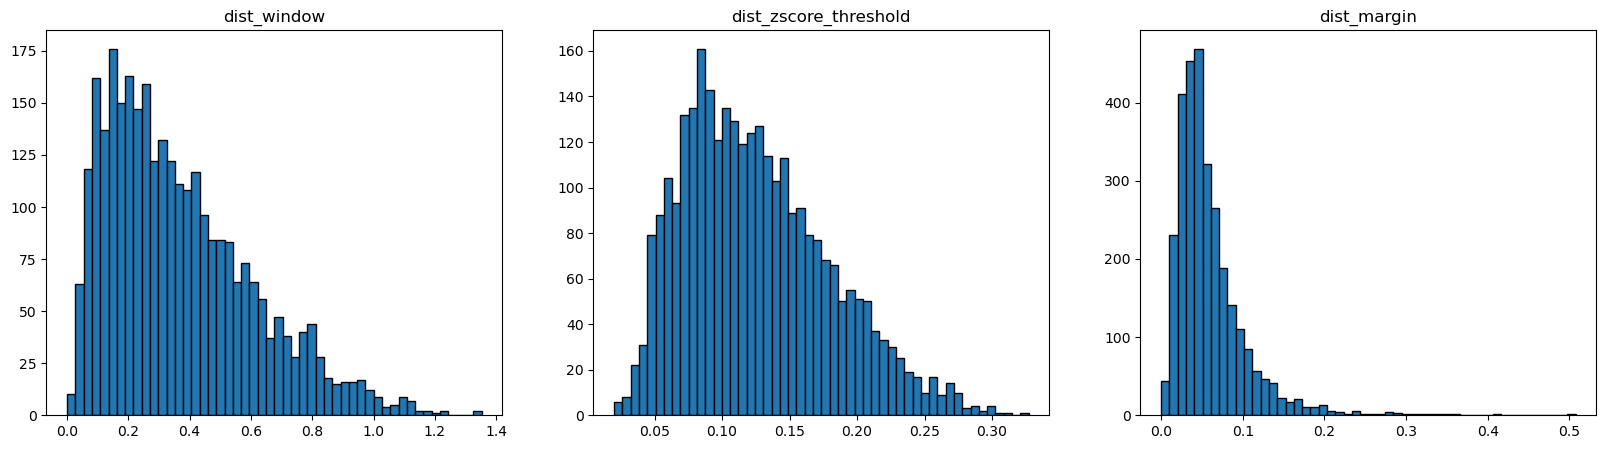

In [55]:
# plot three histograms for window_dist, zscore_threshold_dist, and margin_dist with three subplots
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize = (20, 5))

ax[0].hist(trading_summary_df["dist_window"], bins = 50, edgecolor = "black")
ax[0].set_title("dist_window")

ax[1].hist(trading_summary_df["dist_zscore_threshold"], bins = 50, edgecolor = "black")
ax[1].set_title("dist_zscore_threshold")

ax[2].hist(trading_summary_df["dist_margin"], bins = 50, edgecolor = "black")
ax[2].set_title("dist_margin")

plt.show()


In [56]:
trading_summary_df["diff_margin"] = abs(trading_summary_df["intraday_margin"] - trading_summary_df["predicted_margin"])

In [57]:
df_sel = trading_summary_df[(0.2 <= trading_summary_df.dist_window) & (trading_summary_df.dist_window <= 0.3) 
                            & (trading_summary_df.predicted_margin >= 3100) & 
                            (trading_summary_df.diff_margin <= 50)].sort_values(by="intraday_margin", ascending=False).set_index("pair")

In [58]:
df_sel.index

Index([ ('BAX', 'EXPE'),  ('ABNB', 'UDR'),  ('ACN', 'NTAP'), ('ADBE', 'RVTY'),
       ('QRVO', 'RVTY'),    ('BAX', 'MU'),  ('CRL', 'SWKS'), ('EBAY', 'INTC'),
          ('GE', 'JCI'),  ('META', 'VFC'),  ('TFC', 'ZION'),   ('CFG', 'CZR')],
      dtype='object', name='pair')

In [59]:
def keep_first_occurrence(origin_list):
    # Create a set to keep track of seen stock symbols
    seen = set()
    # Create a result list to keep the non-duplicated pairs
    result = []
    
    # First, add all the unique pairs from the primary_list to the result
    # If a stock symbol has already been seen, it is a duplicate and will not be added
    for pair in origin_list:
        if pair[0] not in seen and pair[1] not in seen:
            seen.update(pair)
            result.append(pair)
    
    
    return seen, result

pairs_set, pairs_list = keep_first_occurrence(df_sel.index)
# pairs_list = pairs_list[0:10]
# select result_statistics_sel based on pairs
df_sel = df_sel[df_sel.index.isin(pairs_list)]

In [60]:
df_sel

,mean_window,median_window,std_window,mean_zscore_threshold,median_zscore_threshold,std_zscore_threshold,mean_margin,median_margin,std_margin,dist_window,...,window,zscore_threshold,intraday_margin,predicted_margin,dist_window_rd,dist_zscore_threshold_rd,dist_margin_rd,mean_margin_rd,intraday_margin_rd,diff_margin
pair,,,,,,,,,,,,,,,,,,,,,
"(BAX, EXPE)",17.85,19.0,4.475371,2.545,2.60,0.193241,8050.647970,7860.227621,398.784242,0.250721,...,18,2.545,3287.107049,3281.051754,0.25,0.08,0.05,8050.65,3287.11,6.055295
"(ABNB, UDR)",22.75,24.0,4.586881,2.340,2.30,0.206219,7136.025005,7064.688824,416.834802,0.201621,...,23,2.340,3223.871229,3228.530160,0.20,0.09,0.06,7136.03,3223.87,4.658932
"(ACN, NTAP)",19.30,17.0,4.092355,2.310,2.30,0.188903,6235.851126,6200.674756,214.301578,0.212039,...,19,2.310,3204.075336,3176.838295,0.21,0.08,0.03,6235.85,3204.08,27.237041
"(ADBE, RVTY)",5.40,5.0,1.500877,2.530,2.55,0.288554,6056.560745,5716.862544,1066.878488,0.277940,...,5,2.530,3183.104625,3166.542668,0.28,0.11,0.18,6056.56,3183.10,16.561956
"(CRL, SWKS)",15.45,17.0,4.285533,2.550,2.60,0.241704,4960.085374,4896.157588,156.266288,0.277381,...,15,2.550,3116.952324,3103.578325,0.28,0.09,0.03,4960.09,3116.95,13.373999
"(EBAY, INTC)",19.10,17.0,4.399761,2.480,2.45,0.331821,5168.172049,5164.918652,237.488266,0.230354,...,19,2.480,3099.185927,3115.527559,0.23,0.13,0.05,5168.17,3099.19,16.341632
"(GE, JCI)",5.05,4.0,1.356272,2.705,2.55,0.646834,5189.923118,4935.637705,703.442308,0.268569,...,5,2.705,3091.301561,3116.776599,0.27,0.24,0.14,5189.92,3091.30,25.475039
"(META, VFC)",18.95,21.0,5.246302,3.195,3.15,0.416091,5254.155529,5060.751659,415.673562,0.276850,...,19,3.195,3081.667532,3120.465101,0.28,0.13,0.08,5254.16,3081.67,38.797569
"(TFC, ZION)",8.80,9.0,2.261811,2.925,2.80,0.373990,5074.585447,5059.772782,218.714759,0.257024,...,9,2.925,3073.709951,3110.153413,0.26,0.13,0.04,5074.59,3073.71,36.443462


In [61]:
print(df_sel.intraday_margin.mean(), df_sel.predicted_margin.mean())

3142.940340490807 3152.539600663244


In [50]:
# save df_sel to a pickle file
df_sel.to_pickle("../data/df_sel.pkl")

# Kaggle Reference
https://www.kaggle.com/code/dtmanager1979/stock-trading-eda-scheduled